# Image classifier

In [1]:
import keras
import numpy as np

# Load the data

In [2]:
# get the data from the keras datasets
(X_train_full, y_train_full), (X_test_full, y_test_full) = keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


| Label | Class          |
|-------|----------------|
| 0     | airplane ✈️    |
| 1     | automobile 🚗  |
| 2     | bird 🐦        |
| 3     | cat 🐱         |
| 4     | deer 🦌        |
| 5     | dog 🐶         |
| 6     | frog 🐸        |
| 7     | horse 🐴       |
| 8     | ship 🚢        |
| 9     | truck 🚚       |

We are going to work classifying airplanes and ships.

In [3]:
# flatten the arrays to work
y_train_full = y_train_full.flatten()
y_test_full = y_test_full.flatten()

Get the indexes of the images we are going to work with

In [4]:
# get the indices of the elements that are plains or ships
train_indexes = np.where((y_train_full == 0) | (y_train_full == 8))[0]
test_indexes = np.where((y_test_full == 0) | (y_test_full == 8))[0]

Now just stay with the revelant images in train and test

In [5]:
# get the images
X_train = X_train_full[train_indexes]
X_test = X_test_full[test_indexes]

y_train = y_train_full[train_indexes]
y_test = y_test_full[test_indexes]

# Visualize the data

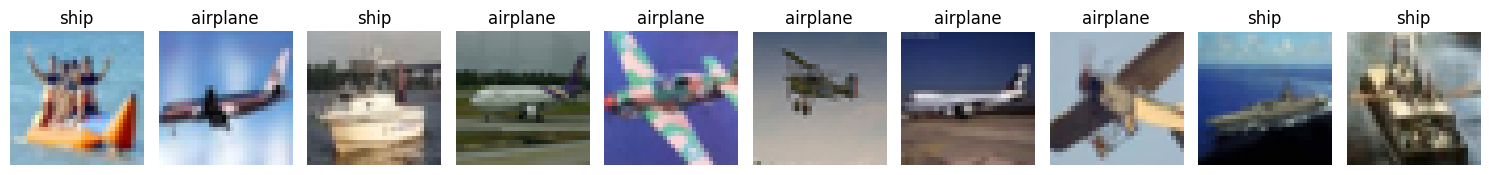

In [6]:
import matplotlib.pyplot as plt


class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Mostrar las primeras 5 imágenes de gatos/perros
plt.figure(figsize=(15, 2))

for i, idx in enumerate(train_indexes[:10]):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train[idx])
    label = class_names[y_train[idx]]
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

array([[[134, 186, 223],
        [131, 184, 220],
        [128, 182, 218],
        ...,
        [127, 181, 222],
        [127, 181, 222],
        [128, 182, 223]],

       [[133, 189, 228],
        [129, 186, 224],
        [128, 186, 224],
        ...,
        [127, 183, 224],
        [127, 183, 224],
        [128, 184, 225]],

       [[128, 185, 226],
        [127, 182, 223],
        [128, 182, 223],
        ...,
        [126, 181, 222],
        [126, 181, 222],
        [126, 180, 221]],

       ...,

       [[174, 208, 235],
        [171, 206, 229],
        [155, 189, 216],
        ...,
        [ 27,  94, 136],
        [ 29,  96, 137],
        [ 28,  94, 136]],

       [[194, 221, 244],
        [189, 215, 239],
        [159, 196, 225],
        ...,
        [ 30,  95, 138],
        [ 30,  96, 139],
        [ 30,  95, 140]],

       [[193, 217, 237],
        [181, 208, 230],
        [168, 201, 227],
        ...,
        [ 31,  94, 136],
        [ 32,  94, 137],
        [ 32,  94, 138]]], dtype=uint8)
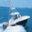

In [7]:
# show the image info
X_train[0]

We can see that the image shape is (32, 32, 3).

In [8]:
# let's create the image shapes
img_height = 32
img_width = 32

In [20]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_train shape: (10000, 32, 32, 3), y_train shape: (10000,)


# Recategorize the data

In [9]:
# change the labels to:
# - airplane = 0
# - ship = 1
y_train = (y_train == 8).astype(np.uint8) # true 1 (ship), false en 0 (airplane).
y_test = (y_test == 8).astype(np.uint8)

,count
class,
0,5000
1,5000


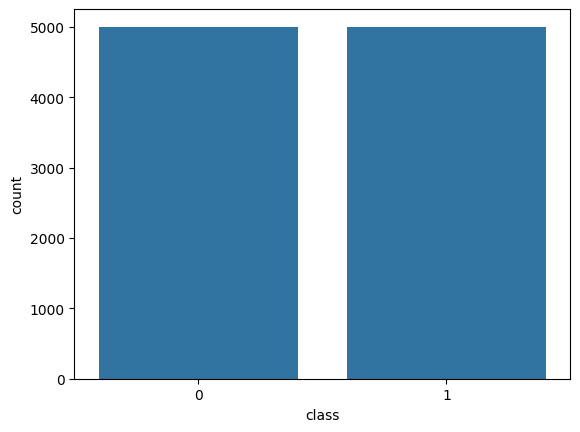

In [10]:
import seaborn as sns
import pandas as pd


sns.countplot(pd.DataFrame(y_train, columns=['class']), x="class")
pd.DataFrame(y_train, columns=['class']).value_counts()

# Standardize the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Now we standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [11]:
# normalization_layer = tf.keras.layers.Rescaling(1./255)

Now there are two ways to use this layer. We can apply it to the dataset by calling Dataset.map:

In [12]:
# normalize all the data
# normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# let's print the first image to see the normalization
# image_batch, labels_batch = next(iter(normalized_train_ds))
# first_image = image_batch[0]
# print('Min and Max values:', np.min(first_image), '-', np.max(first_image))

Or we can include this layer in the model, the same can be done with the Resizing using the **tf.keras.layers.Resizing** layer (we are going to do this option).

# Now let's create the model (CNN)

This time we are following the models given to use:

In [31]:
from keras import Sequential, layers, regularizers


model = Sequential([
    # set this Input layer to delete the warning
    layers.Input(shape=(img_height, img_width, 3)),
    # here is where the rescaling layer can be
    layers.Rescaling(1./255),

    # rest of the layers
    layers.Conv2D(filters = 32, kernel_size = (3,3), padding = "same", activation = "relu", kernel_regularizer=regularizers.L2(0.001)),
    layers.Conv2D(filters = 32,kernel_size = (3,3),padding = "same", activation = "relu", kernel_regularizer=regularizers.L2(0.001)),
    layers.MaxPool2D(pool_size = (2,2),strides = (2,2)),
    # dropout layer
    layers.Dropout(0.5),

    layers.Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu", kernel_regularizer=regularizers.L2(0.001)),
    layers.Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu", kernel_regularizer=regularizers.L2(0.001)),
    layers.MaxPool2D(pool_size = (2,2),strides = (2,2)),
    # dropout layer
    layers.Dropout(0.5),

    layers.Flatten(),
    layers.Dense(units = 512,activation = "relu", kernel_regularizer=regularizers.L2(0.001)),
    # dropout layer
    layers.Dropout(0.5),
    layers.Dense(units = 512,activation = "relu", kernel_regularizer=regularizers.L2(0.001)),
    # dropout layer
    layers.Dropout(0.5),

    # output layer
    layers.Dense(units=1, activation='sigmoid')
])

# Compile the model

This time we are going to use the **tf.keras.optimizers.Adam** optimizer and **tf.keras.losses.SparseCategoricalCrossentropy** loss function.

In [32]:
model.compile(
    optimizer='adam',
    loss=['binary_crossentropy'], # use this loss function based on the binary classification
    metrics=['accuracy'] # we can use accuracy because the training data is balanced
)

# Model summary

We can see all the layers of the network using the Keras **Model.summary** method:

In [33]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,401 (9.26 MB)

 Trainable params: 2,426,401 (9.26 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model

Early stopping conf

In [34]:
from keras.src.callbacks import EarlyStopping


early_stopping = EarlyStopping(
    monitor='val_loss',         # metric to verify
    patience=25,                 # number of epochs without change to stop
    restore_best_weights=True
)

Learning rate scheduler

In [35]:
from keras.src.callbacks import LearningRateScheduler


def scheduler(epoch, lr):
    """
    Scheduler that reduces the learning rate by 10.
    """
    if epoch < 10:
        return lr
    else:
        return lr * 0.1

lr_scheduler = LearningRateScheduler(scheduler)

Fitting of the model

In [36]:
# epoch to train
epochs = 200

# train
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=epochs,
    callbacks=[early_stopping],
    batch_size=64,
    validation_data=(X_test, y_test)
)

Epoch 1/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.5550 - loss: 1.3930 - val_accuracy: 0.6955 - val_loss: 0.6396
Epoch 2/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7258 - loss: 0.6197 - val_accuracy: 0.7030 - val_loss: 0.6296
Epoch 3/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7398 - loss: 0.5853 - val_accuracy: 0.7540 - val_loss: 0.5525
Epoch 4/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7632 - loss: 0.5561 - val_accuracy: 0.8155 - val_loss: 0.4849
Epoch 5/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7965 - loss: 0.5150 - val_accuracy: 0.8060 - val_loss: 0.4944
Epoch 6/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8100 - loss: 0.4923 - val_accuracy: 0.8270 - val_loss: 0.4701
Epoch 7/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8214 - loss: 0.4828 - val_accuracy: 0.8430 - val_loss: 0.4414
Epoch 8/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8265 - loss: 0.4646 - val_ac

# Visualize training results

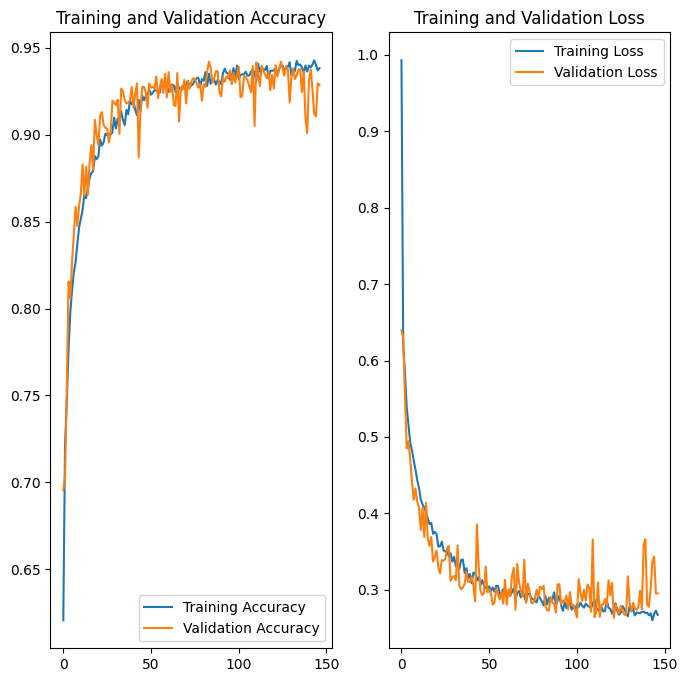

In [37]:
# get the values to graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['val_accuracy']))

# create the graphs
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We can see that the model learned to classify images and it is not overffited.

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
AUC Score: 0.9864


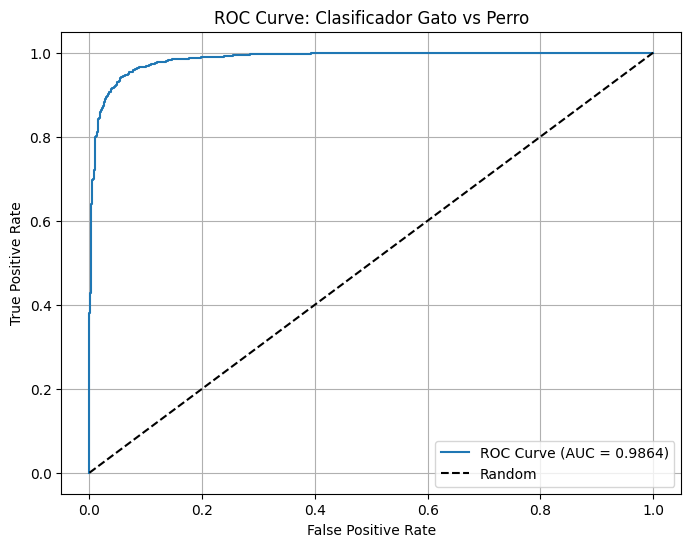

In [39]:
from sklearn.metrics import roc_auc_score, roc_curve


# calculate the proba predicts
y_proba = model.predict(X_test).flatten()

# calculate the AUC score
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC Score: {auc_score:.4f}")

# graph the AUC plot
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Clasificador Gato vs Perro')
plt.legend()
plt.grid(True)
plt.show()

The model has a good accuracy and AUC score and is not overfitted. The model created is "optimized" and not a base model because practicing with the cat vs dogs dataset this was the model that at some pint actually learned something but not in a repetly manner.

# Save the model

In [38]:
model.save(f'base_model.keras')

Now clear the memory to continue working

In [ ]:
from keras.src.backend.common.global_state import clear_session

clear_session(
    free_memory=True
)